This is still the original task: predict university admission. This time, only neural networks will be used for personal practice.

In [1]:
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np

taking the same steps with the data as the other file...

<h2> Get the Data

In [2]:
df = pd.read_csv("Data/Admission_Predict_Ver1.1.csv")
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
# indexing on Serial No.
df.set_index('Serial No.', inplace = True)

<h2> Data exploration/cleaning

In [4]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
# All of our given features
columns = df.columns.values
columns

array(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ',
       'CGPA', 'Research', 'Chance of Admit '], dtype=object)

Note that the chance of admission and letter of reccomendation column have an additional whitespace at the end of their respective column names. This might lead to issues/confusion, so first removing these whitespaces

In [6]:
col_fix = []
for col in columns:
    col_fix += [col.strip()]
df.columns = col_fix
df.columns.values

array(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR',
       'CGPA', 'Research', 'Chance of Admit'], dtype=object)

There is not much else to do in terms of data cleaning, this dataset was made nicely on purpose. This means we can go straight into analysis and exploration of the data

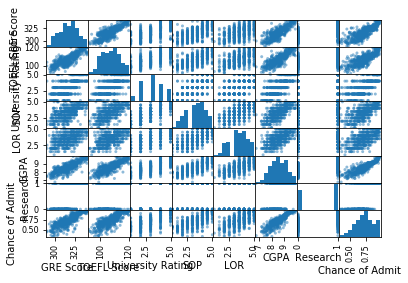

In [7]:
scatter_matrix(df)
plt.show()

The research category is extremely binary and may not be as useful to include as a feature in our model. Let's look more in depth into it to determine if we should remove it.

Majority of the features appear to be linearly correlated with each other, which could potentially be an issue in the context of multicollinearity. This will be addressed after dealing with the research column.

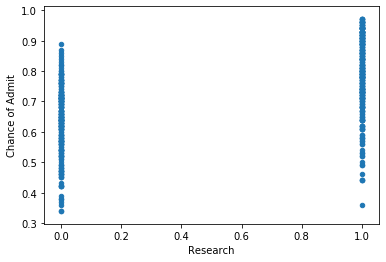

In [8]:
df.plot(x = 'Research', y = 'Chance of Admit', kind = 'scatter')

It appears that people that have research generally have a higher chance of admissions so we will keep this as a feature.

Now let us determine if multicollinearity will be an issue. The variance inflation factor (VIF) will be used to determine the significance of the effect of multicollinearity. Note that this was ignored in the other version.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_calc(features):
    vif = pd.DataFrame()
    vif['features'] = features.columns
    vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return vif

In [10]:
X_temp = df.copy()
X_temp.insert(0,'Intercept', 1)
X_temp.drop(columns = ['Chance of Admit'], inplace = True)
vif = vif_calc(X_temp)
vif

,features,VIF
0,Intercept,1511.495830
1,GRE Score,4.464249
2,TOEFL Score,3.904213
3,University Rating,2.621036
4,SOP,2.835210
5,LOR,2.033555
6,CGPA,4.777992
7,Research,1.494008


Using the general guideline for VIF[1] GRE, CGPA and TOEFL will be further analyzed to see if any corrections need to be made. <br>
[1] https://online.stat.psu.edu/stat462/node/180/#:~:text=As%20the%20name%20suggests%2C%20a,much%20the%20variance%20is%20inflated.&text=The%20general%20rule%20of%20thumb,of%20serious%20multicollinearity%20requiring%20correction.

<h3> GRE, CGPA, TOEFL analysis

It makes logical sense that these 3 features have a high variance inflation factor. People who have a higher GPA will most likely score higher on the TOEFL and GRE, because these 2 examinations are based in acadeamics. <br>

The main difference between the GRE and TOEFL is that the GRE is used to see how well a student can take graduate-level coursework and TOEFL is used to measure the participant's skill in English [2].


[2]https://www.prepscholar.com/toefl/blog/gre-and-toefl/#:~:text=The%20TOEFL%20and%20GRE%20are,TOEFL%20measures%20English%20language%20skills.&text=It's%20possible%20you%20may%20have%20to%20take%20both%20exams.

In [11]:
temp = df[['GRE Score', 'TOEFL Score', 'CGPA', 'Chance of Admit']]
temp.corr(method = 'pearson')

,GRE Score,TOEFL Score,CGPA,Chance of Admit
GRE Score,1.000000,0.827200,0.825878,0.810351
TOEFL Score,0.827200,1.000000,0.810574,0.792228
CGPA,0.825878,0.810574,1.000000,0.882413
Chance of Admit,0.810351,0.792228,0.882413,1.000000


From the correlation matrix, it seems that there is a high correlation (>0.8) between all three features. However, since the TOEFL score has the lowest correlation coefficient to the Chance of admission, we will drop the TOEFL score. 

**NOTE**: a low correlation coefficient does not necessarily mean that the feature is unrelated to the target. It simply means that there is a *weak linear relationship*. It's entirely possible for that feature to be related to the target, albeit it would be a higher dimension relationship. 

In [12]:
df.drop(columns = ['TOEFL Score'], inplace = True)
df.head()

,GRE Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,
1,337,4,4.5,4.5,9.65,1,0.92
2,324,4,4.0,4.5,8.87,1,0.76
3,316,3,3.0,3.5,8.00,1,0.72
4,322,3,3.5,2.5,8.67,1,0.80
5,314,2,2.0,3.0,8.21,0,0.65


In [13]:
X_temp = df.copy()
X_temp.insert(0,'Intercept', 1)
X_temp.drop(columns = ['Chance of Admit'], inplace = True)
vif = vif_calc(X_temp)
vif

,features,VIF
0,Intercept,1507.566509
1,GRE Score,3.520718
2,University Rating,2.600871
3,SOP,2.808895
4,LOR,2.033534
5,CGPA,4.398687
6,Research,1.490598


While the VIF has gone down, it is still high for GRE and CGPA. It would be best if we can merge these 2 columns into one. Let's divide each column by their respective max score, then multiply those 2 values to obtain our metric for academic potential/ability

In [14]:
df['GRE Score'] = df['GRE Score'].divide(340)
df['CGPA'] = df['CGPA'].divide(10)
df.head()

,GRE Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,
1,0.991176,4,4.5,4.5,0.965,1,0.92
2,0.952941,4,4.0,4.5,0.887,1,0.76
3,0.929412,3,3.0,3.5,0.800,1,0.72
4,0.947059,3,3.5,2.5,0.867,1,0.80
5,0.923529,2,2.0,3.0,0.821,0,0.65


In [15]:
df['Academics'] = df['GRE Score'] * df['CGPA']
df.head()

,GRE Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Academics
Serial No.,,,,,,,,
1,0.991176,4,4.5,4.5,0.965,1,0.92,0.956485
2,0.952941,4,4.0,4.5,0.887,1,0.76,0.845259
3,0.929412,3,3.0,3.5,0.800,1,0.72,0.743529
4,0.947059,3,3.5,2.5,0.867,1,0.80,0.821100
5,0.923529,2,2.0,3.0,0.821,0,0.65,0.758218


We can now drop GRE and CGPA

In [16]:
df.drop(columns = ['GRE Score', 'CGPA'], inplace = True)
df.head()

,University Rating,SOP,LOR,Research,Chance of Admit,Academics
Serial No.,,,,,,
1,4,4.5,4.5,1,0.92,0.956485
2,4,4.0,4.5,1,0.76,0.845259
3,3,3.0,3.5,1,0.72,0.743529
4,3,3.5,2.5,1,0.80,0.821100
5,2,2.0,3.0,0,0.65,0.758218


In [17]:
X_temp = df.copy()
X_temp.insert(0,'Intercept', 1)
X_temp.drop(columns = ['Chance of Admit'], inplace = True)
vif = vif_calc(X_temp)
vif

,features,VIF
0,Intercept,161.521096
1,University Rating,2.607537
2,SOP,2.789975
3,LOR,1.997526
4,Research,1.428483
5,Academics,2.830847


We can now see that our VIF scores are all satisfactory

<h2> Model Preparation

Now that we've cleaned our data and condensed several features, we can now begin to separate our data to put into our model

In [18]:
from sklearn.model_selection import train_test_split
X = df.copy()
X.drop(columns = ['Chance of Admit'], inplace = True)
y = df['Chance of Admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
# scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<h3> Model Creation

Because of the small # of available samples, we will be using 2 Dense layers and use iterated k fold with shuffling to create a more accurate model. To avoid overfitting, we will also be using l1 regularization.

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
def model_create():
    model = Sequential()
    model.add(Dense(20, kernel_initializer='normal', activation = 'relu', input_dim = 5))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal', activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

Using TensorFlow backend.


Using Kfolds

In [21]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

estimator = KerasRegressor(build_fn = model_create, epochs = 500, batch_size = 500, verbose=0)
kfold = KFold(n_splits=15)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %f (%f) MSE" % (results.mean(), results.std()))

Baseline: -0.004023 (0.001619) MSE


<h2> Final Evaluation

Now that we have our model (*estimator*) we can evaluate it on our test data set

In [22]:
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("Final mean squared error: %f      R^2 value: %f" %(mean_squared_error(y_test, predictions), r2_score(y_test, predictions)))

Final mean squared error: 0.003742      R^2 value: 0.808306


Note that there are 3 main areas that we can choose to tune our model:
1. in our function *model_create*, we can add/remove more layers and tweak the parameters of those layers to obtain a better model. Note that we have a limited sample size so a large # of nodes is not required
2. we can change the # of epochs to use
3. we can choose the # of folds to use (i.e. change value of k for kfolds)